# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
import vbranch as vb
from vbranch.applications.resnet import ResNet50
from vbranch.applications.cnn import SimpleCNNLarge

from vbranch.utils.training import wrap_iterator, get_data_iterator_from_generator, lr_exp_decay_scheduler
from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet

In [3]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'res'
DATASET = 'market'
NUM_BRANCHES = 1
SHARED_FRAC = None

EPOCHS = 150
STEPS_PER_EPOCH = 100
T_0 = 50
OUTPUT_DIM = 128

## Load Data

In [4]:
P, K = 18, 4
train_generator = vb.datasets.reid.TripletDataGenerator(DATASET, 'train')

In [5]:
batch = train_generator.next(4, 4, flatten=False, preprocess=False)

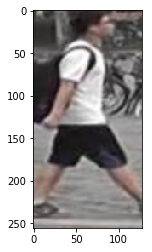

In [6]:
plt.imshow(batch[3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [7]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/market-res_1


In [8]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

tf.reset_default_graph()

inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, input_dim, 
                                                                       P,K, n=NUM_BRANCHES)

(None, 256, 128, 3)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
inputs

<tf.Tensor 'IteratorGetNext:0' shape=(?, 256, 128, 3) dtype=float32>

In [10]:
lr = tf.placeholder('float32', name='lr')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'res':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, weights='imagenet')
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    # Compile model
    model.compile(optimizer, triplet(model.output, P, K, name='loss'), 
                  train_init_op, test_init_op, 
                  callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES)},
                  schedulers={'lr:0': lr_scheduler}, 
                  assign_ops=assign_ops)

model.summary()

Loading weights for ResNet50...
Custom loss used...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
i    Layer name                      Output shape      Parameters              Num param  Inbound            
-------------------------------------------------------------------------------------------------------------
     Input                           [None,256,128,3]                                                        
-------------------------------------------------------------------------------------------------------------
0    conv1 (Conv2D)                  [None,128,64,64]  [7,7,3,64] [64]         9472       IteratorGetNext:0  
-------------------------------------------------------------------------------------------------------------
1    bn_conv1 (BatchNormalization)   [None,128,64,64]  [64] [64]               128        conv1              
----------------------------------------------------

In [11]:
print(model.output)

Tensor("model/output/output:0", shape=(?, 128), dtype=float32)


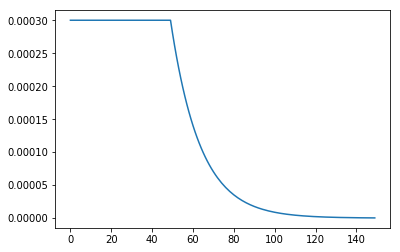

In [12]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [ ]:
history = model.fit({}, EPOCHS, STEPS_PER_EPOCH,
                    val_dict=None, log_path=model_path if SAVE else None, 
                    call_step=10)

Epoch 1/150
 - 73s - loss: 1536.3031
Epoch 2/150
 - 60s - loss: 992.4093
Epoch 3/150
 - 59s - loss: 284.9516
Epoch 4/150
 - 60s - loss: 101.8877
Epoch 5/150
 - 60s - loss: 76.6936
Epoch 6/150
 - 60s - loss: 66.7187
Epoch 7/150
 - 60s - loss: 60.5537
Epoch 8/150
 - 59s - loss: 56.1663
Epoch 9/150
 - 60s - loss: 51.6003
Epoch 10/150
Computing gallery embeddings...
15913/15913 [==============================] - 56s 3ms/step
Computing query embeddings...
3368/3368 [==============================] - 12s 4ms/step
Computing rank ([1, 5]) and mAP (True) scores...
3368/3368 [==============================] - 60s 18ms/step
 - 188s - loss: 52.2678 - rank1: 0.0401 - mAP: 0.0200 - rank5: 0.1327
Epoch 11/150
 - 57s - loss: 49.9776
Epoch 12/150
 - 58s - loss: 49.6969
Epoch 13/150
 - 59s - loss: 47.7391
Epoch 14/150
 - 58s - loss: 46.3495
Epoch 15/150
 - 58s - loss: 47.4673
Epoch 16/150
 - 58s - loss: 47.5628
Epoch 17/150
 - 58s - loss: 47.8604
Epoch 18/150
 - 58s - loss: 44.2978
Epoch 19/150
 - 58s -

## Evaluation

### Baseline

In [15]:
assert NUM_BRANCHES == 1

model_id_list = [1]
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_one_shot(sess, model_name='model_'+str(model_id))
        print('Model {} acc:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('Mean acc:', np.mean(baseline_acc_list), ', std:', np.std(baseline_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/omniglot-res_1/ckpt
Model 1 acc: 0.8049999999999999
Mean acc: 0.8049999999999999 , std: 0.0


### Virtual Branching

In [8]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)    
        acc, branch_acc = vbranch_one_shot(sess, model_name='model_'+str(model_id), 
                                           n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/vb-omniglot-res-B2-S0.25_1/ckpt
Model 1 acc: 0.8375 [0.7849999999999999, 0.8125]
Mean acc: 0.8375 , std: 0.0
